<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#true-positives" data-toc-modified-id="true-positives-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>true positives</a></span></li><li><span><a href="#false-positives" data-toc-modified-id="false-positives-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>false positives</a></span></li><li><span><a href="#false-negatives" data-toc-modified-id="false-negatives-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>false negatives</a></span></li><li><span><a href="#true-positives" data-toc-modified-id="true-positives-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>true positives</a></span></li><li><span><a href="#false-positives" data-toc-modified-id="false-positives-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>false positives</a></span></li><li><span><a href="#false-negatives" data-toc-modified-id="false-negatives-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>false negatives</a></span></li></ul></div>

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from skimage import io, color, transform, feature, exposure, filters, morphology
import my_measures # note, this was updated March 27; make sure you are using the current version! 
%matplotlib inline

In [145]:
# file paths/names

root_dir = '/Users/aucherserr/Desktop/MachineLearning/myGit/ml/mlAssignment2/plane_data/'

ci_path = root_dir + '/cropped_images_18/' # cropped images for training
l_file = root_dir + '/plane_labels_2018.csv' # csv with labels

# get labels and extract features from images

In [146]:
# all labels
plane_data = pd.read_csv(l_file)
print(plane_data.head())
print(plane_data.shape)

                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
(6758, 2)


In [220]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
# dims = (15, 35) # 25% of the original size, 525 pixels
dims = (18, 42) # 30% of the original size, 525 pixels

In [ ]:
## Testing out making a mask



downscaled image shape: 
(18, 84)
image representation (first row of pixels): 
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   6.28642738e-09   6.28642738e-09
   6.28642738e-09   6.28642738e-09   6.28642738e-09   6.28642738e-09
   6.28642738e-09   6.28642738e-09   6.28642738e-09   6.28642738e-09
   6.28642738e-09   6.28

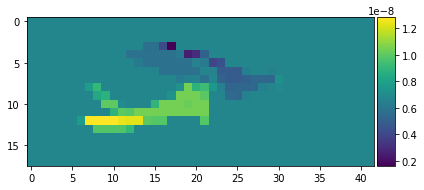

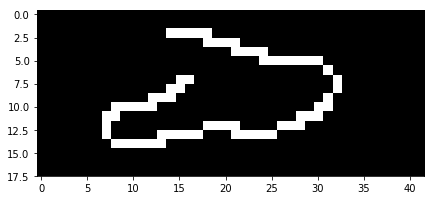

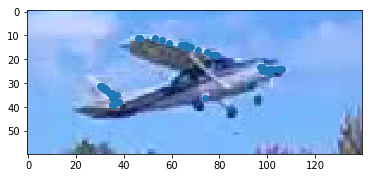

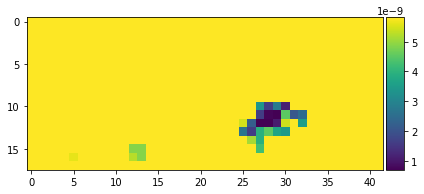

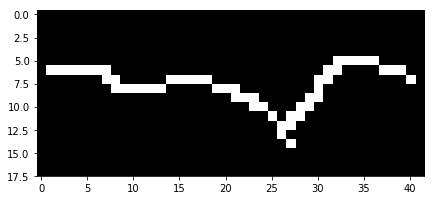

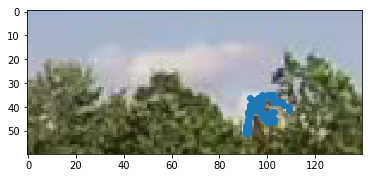

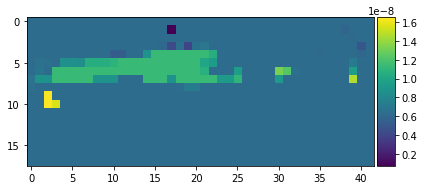

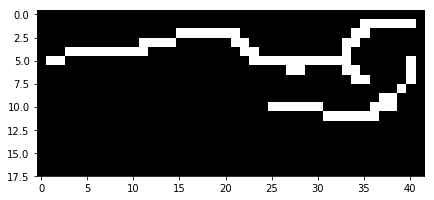

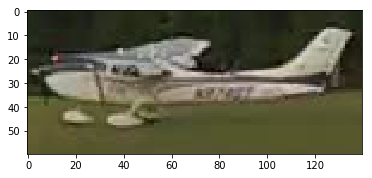

In [278]:
# scikit-image documentation on methods used for feature extraction: 
#    http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray
#    http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
#    http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

def image_manipulation(imname, imview=False):
    warnings.filterwarnings('ignore')
    imname = ci_path + imname + '.png'
    img_raw = io.imread(imname)
    gray = color.rgb2gray(img_raw) # remove color
#     gray = exposure.equalize_hist(gray)

#     filtered = filters.scharr(gray)
    filtered = filters.sobel(gray)
    filtered_downscale = transform.resize(filtered, (dims[0], dims[1]))
    final_image = feature.canny(filtered_downscale, sigma = 2)

#     downscaled = transform.resize(gray, (dims[0], dims[1])) # downscale image
#     final_image = feature.canny(downscaled) # edge filter image with Canny algorithm


    light_spots = np.array((gray > .9).nonzero()).T
    dark_spots = np.array((gray < .1).nonzero()).T
#     print(light_spots.shape)
#     print(dark_spots.shape)
    
    from scipy import ndimage as ndi
    bool_mask = np.zeros(gray.shape, dtype=np.bool)
    bool_mask[tuple(light_spots.T)] = True
    bool_mask[tuple(dark_spots.T)] = True
    seed_mask, num_seeds = ndi.label(bool_mask)
    
    masked = morphology.watershed(filtered, seed_mask, connectivity=2)
    downsized_mask = transform.resize(masked,(dims[0], dims[1]))
    
    if imview==True:
        plt.figure()
        io.imshow(downsized_mask)
#         plt.figure()
#         io.imshow(filtered)
        plt.figure()
        io.imshow(final_image)        
#         plt.figure()
#         io.imshow(final_image_sobel)
        plt.figure()
        plt.plot(light_spots[:,1], light_spots[:, 0], 'o')
#         plt.plot(dark_spots[:,1], dark_spots[:, 0], 'o')
        plt.imshow(img_raw)
    warnings.filterwarnings('always')
    return np.concatenate([final_image, downsized_mask], axis = 1)

# test the function, look at input/output
test_image = image_manipulation('2016-10-07T17+44+06_330Z', True)
test_image = image_manipulation('2017-08-19T19+34+08_350Z', True)
test_image = image_manipulation('2017-07-16T23+13+31_720Z', True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

# [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.
#   1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
#   0.  0.  0.  0.  0.  0.]

In [279]:
# construct lists for features, labels, and a crosswalk reference to image names

features_list = []
y_list = []
imnames_list = []

for index, row in plane_data.iterrows(): 
    features_list.append(image_manipulation(row['img_name']))
    y_list.append(row['plane'])
    imnames_list.append(row['img_name'])
    

In [280]:
print(imnames_list[0])
features_list[0]

2016-08-02T13+50+24_430Z


array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.16415322e-09,   1.16415322e-09,   1.16415322e-09],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.16415322e-09,   1.16415322e-09,   1.16415322e-09],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.16415322e-09,   1.16415322e-09,   1.16415322e-09],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.16415322e-09,   1.16415322e-09,   1.16415322e-09],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.16415322e-09,   1.16415322e-09,   1.16415322e-09],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.16415322e-09,   1.16415322e-09,   1.16415322e-09]])

In [281]:
# convert the lists to ndarrays
features = np.asarray(features_list)
Y = np.asarray(y_list)
imgs = np.asarray(imnames_list)
print('Shape of original feature representation: ')
print(features.shape)

# flatten the images ndarray to one row per image
features_flat = features.reshape((features.shape[0], -1))

print('Shape of flat feature representation: ')
print(features_flat.shape)

print('Shape of Y: ')
print(Y.shape)

print('Number of images with planes: ')
print(Y.sum())

Shape of original feature representation: 
(6758, 18, 84)
Shape of flat feature representation: 
(6758, 1512)
Shape of Y: 
(6758,)
Number of images with planes: 
101


In [282]:
# create train and test sets
from sklearn.model_selection import train_test_split

data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
    Y, imgs, test_size = 0.25, random_state = 12)

print('Shape of training set: ')
print(y_train.shape)
print('Number of training images that contain an airplane: ')
print(y_train.sum())

print(' ')

print('Shape of test set: ')
print(y_test.shape)
print('Number of test images that contain an airplane: ')
print(y_test.sum())

Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
75
 
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
26


# train Perceptron

In [289]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(data_train, y_train)

prc_performance = my_measures.BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = my_measures.BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(prc_performance_test.performance_measures)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices

TRAINING SET: 
{'Pos': 75, 'Neg': 4993, 'TP': 63, 'TN': 4985, 'FP': 8, 'FN': 12, 'Accuracy': 0.99605367008681922, 'Precision': 0.88732394366197187, 'Recall': 0.83999999999999997, 'desc': 'prc', 'set': 'train'}
TEST SET: 
{'Pos': 26, 'Neg': 1664, 'TP': 13, 'TN': 1653, 'FP': 11, 'FN': 13, 'Accuracy': 0.98579881656804735, 'Precision': 0.54166666666666663, 'Recall': 0.5, 'desc': 'prc', 'set': 'test'}


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [290]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
#         print(imnames_list[img])
        warnings.filterwarnings('ignore')    
        plt.figure()
        print(imgs_test[img])
        plt.title(imgs_test[img])
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')


# look at examples of Perceptron classifications

## true positives

2017-07-16T23+13+31_720Z


ValueError: cannot reshape array of size 1512 into shape (18,42)

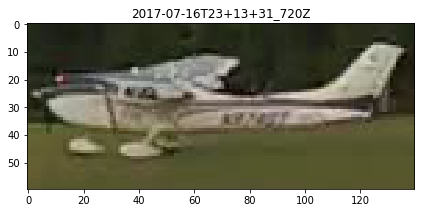

In [291]:
performance_examples('TP', prc_img_indices_to_view)

## false positives

2017-08-19T19+34+08_350Z
2017-09-13T12+14+57_780Z
2017-07-03T14+07+56_980Z
2016-08-17T14+14+45_770Z
2017-07-10T21+59+50_790Z
2016-08-22T11+51+21_520Z
2016-08-22T12+00+07_601Z


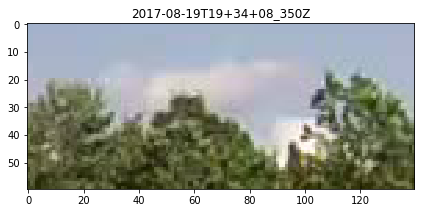

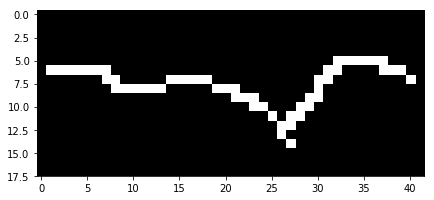

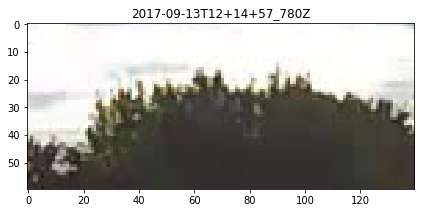

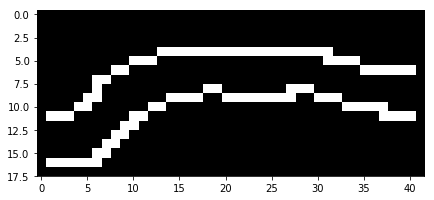

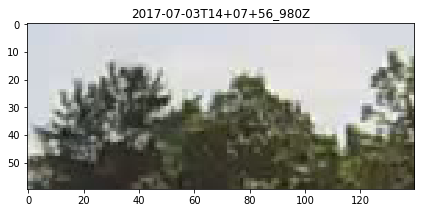

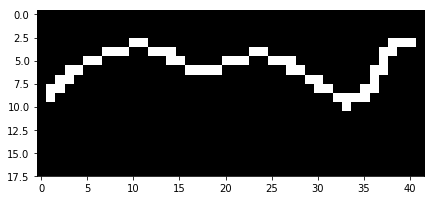

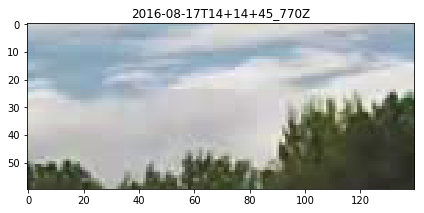

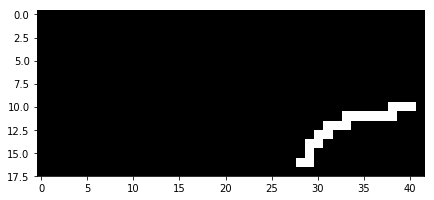

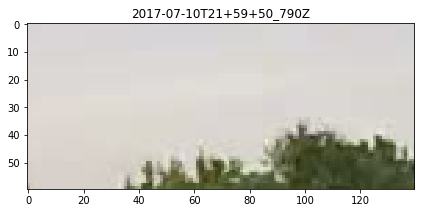

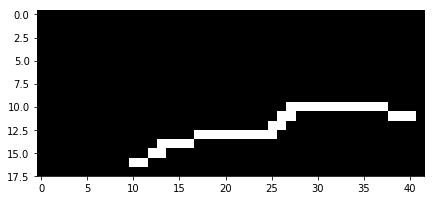

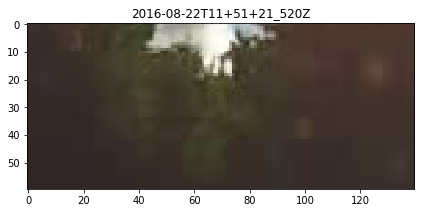

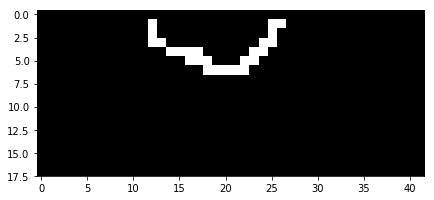

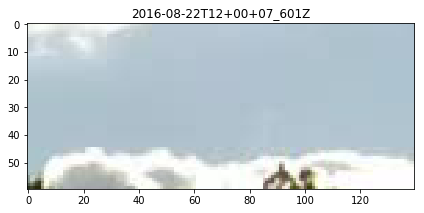

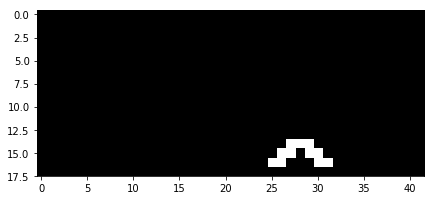

In [195]:
performance_examples('FP', prc_img_indices_to_view)

## false negatives

2017-07-09T15+59+51_510Z
2016-10-16T14+19+27_180Z
2016-10-07T17+44+06_330Z
2017-06-28T18+23+15_110Z
2017-09-26T15+12+02_130Z
2017-09-18T19+59+22_050Z
2017-07-05T23+05+37_890Z
2017-06-28T13+18+49_610Z
2016-08-28T13+58+11_200Z
2017-07-12T17+56+20_210Z
2016-11-12T19+05+51_000Z
2017-07-09T18+27+26_140Z
2017-07-23T16+58+24_610Z
2017-12-01T15+51+08_650Z
2017-06-28T18+20+25_840Z
2017-11-23T12+49+59_380Z
2017-08-25T23+25+36_990Z


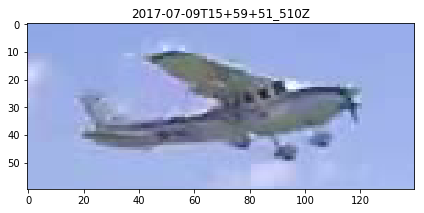

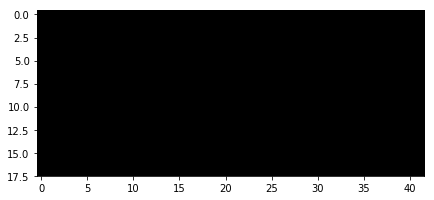

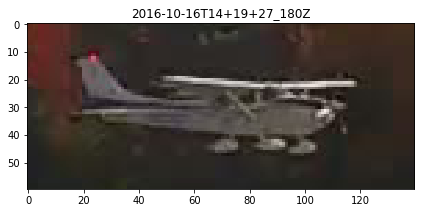

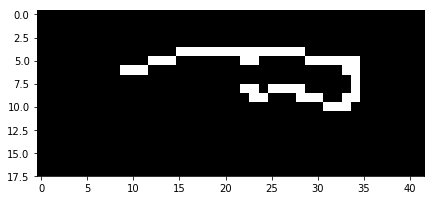

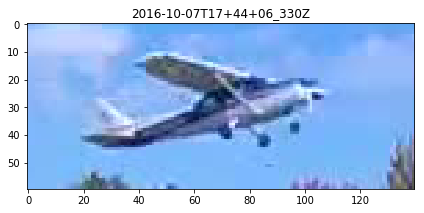

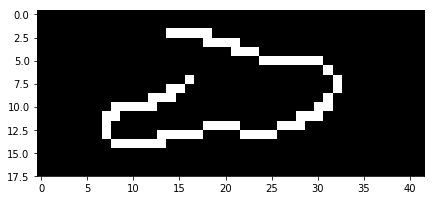

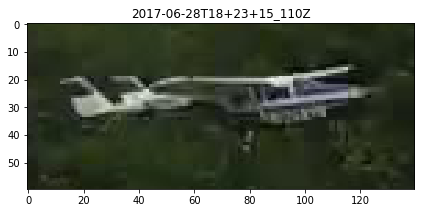

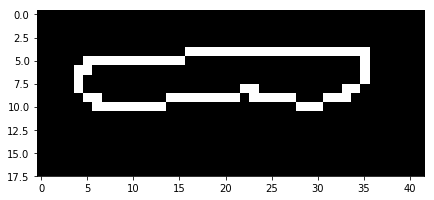

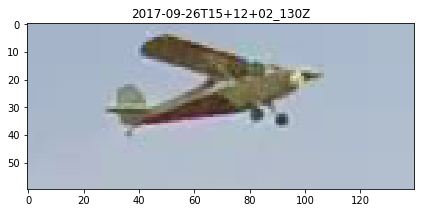

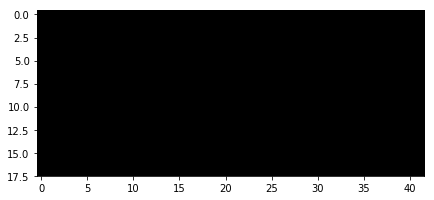

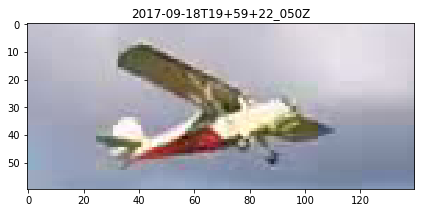

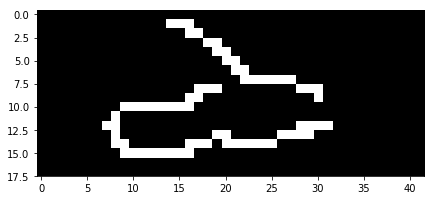

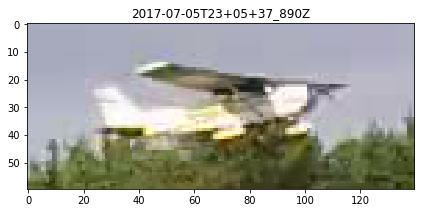

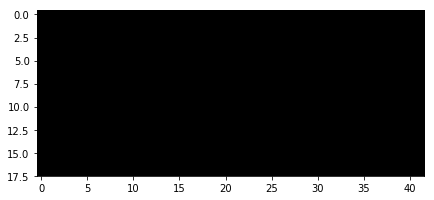

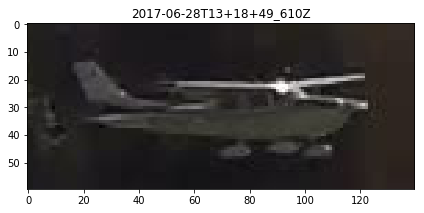

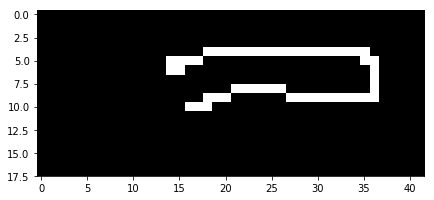

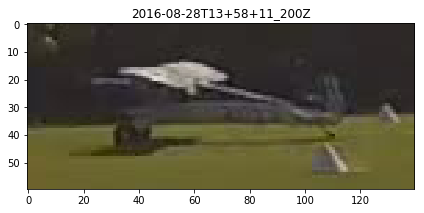

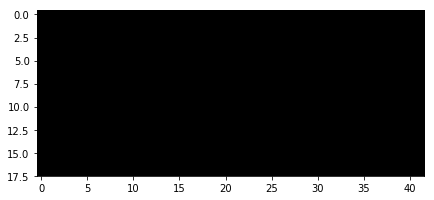

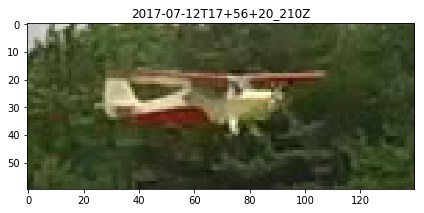

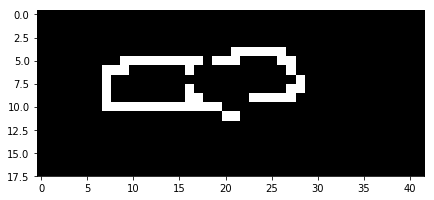

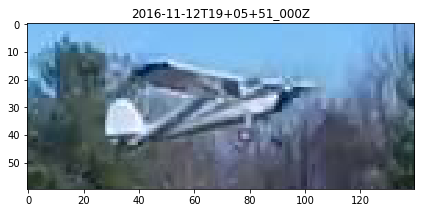

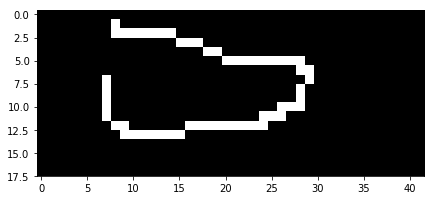

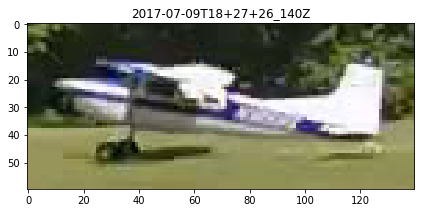

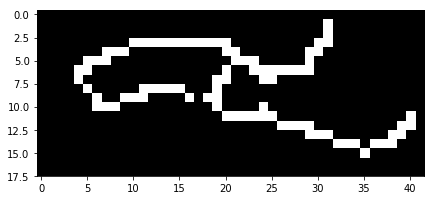

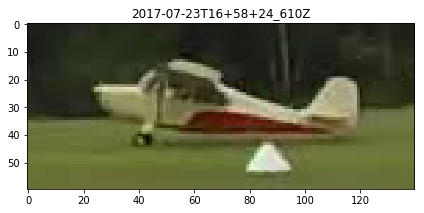

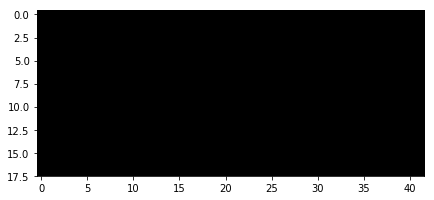

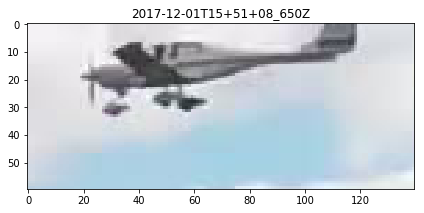

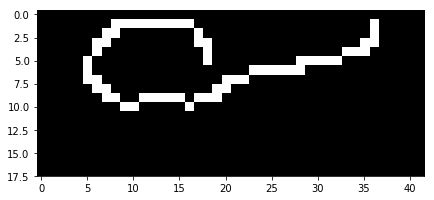

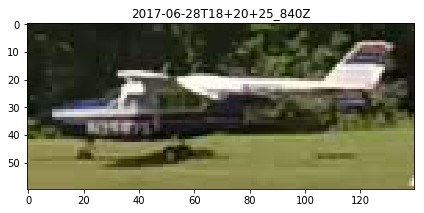

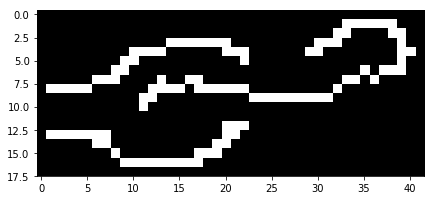

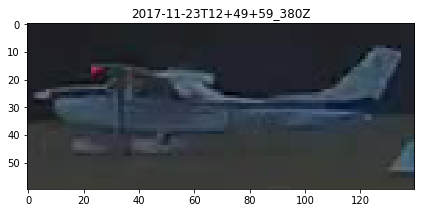

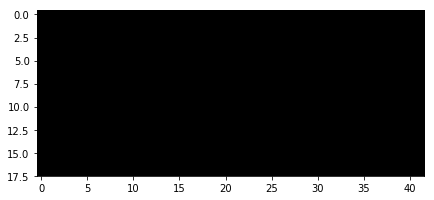

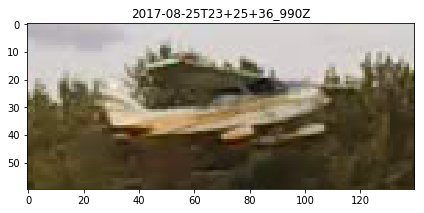

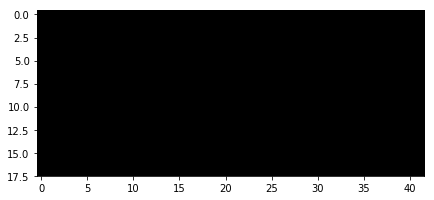

In [196]:
performance_examples('FN', prc_img_indices_to_view)

# train Multilayer Perceptron, a.k.a. neural network

In [132]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(max_iter=1000)
print(nn)
nn.fit(data_train, y_train)

nn_performance = my_measures.BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance.compute_measures()
nn_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance.performance_measures)

nn_performance_test = my_measures.BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test.performance_measures)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
TRAINING SET: 
{'Pos': 75, 'Neg': 4993, 'TP': 75, 'TN': 4993, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 26, 'Neg': 1664, 'TP': 7, 'TN': 1662, 'FP': 2, 'FN': 19, 'Accuracy': 0.98757396449704138, 'Precision': 0.77777777777777779, 'Recall': 0.26923076923076922, 'desc': 'nn_test', 'set': 'test'}


# look at examples of neural network classifications

## true positives

2016-10-16T14+19+27_180Z
2017-07-16T23+13+31_720Z
2016-12-04T14+31+37_880Z
2017-07-16T19+22+59_630Z
2016-08-15T14+26+53_630Z
2017-07-23T16+58+24_610Z
2017-07-05T14+24+52_340Z


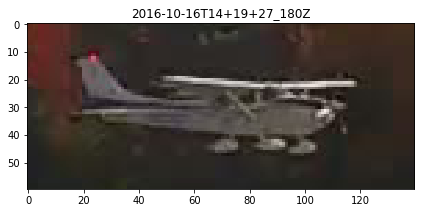

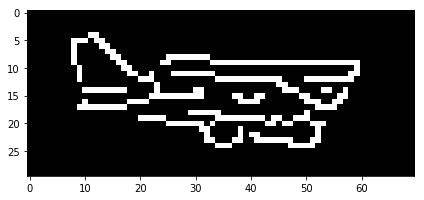

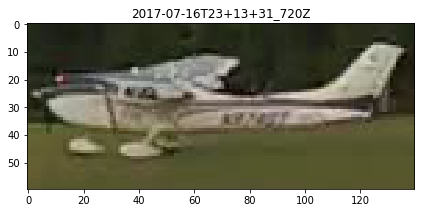

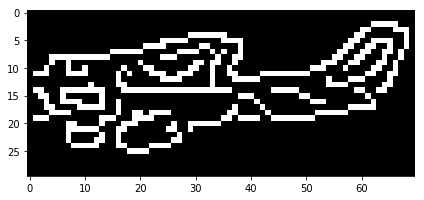

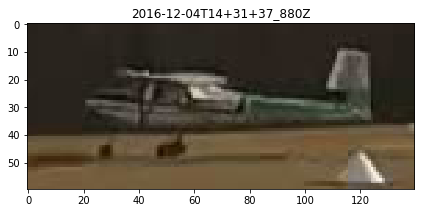

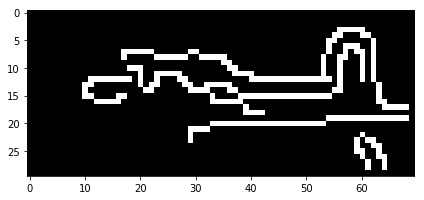

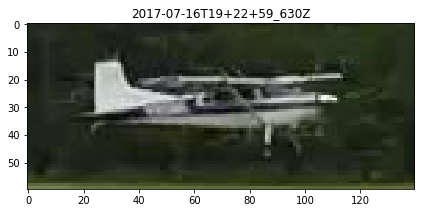

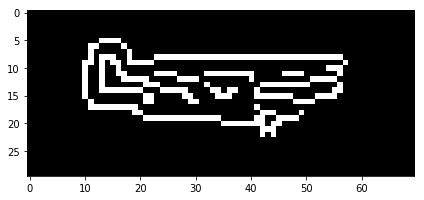

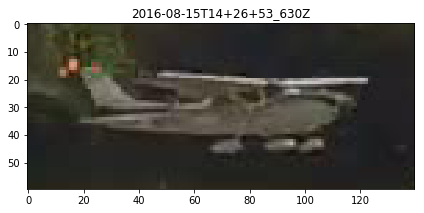

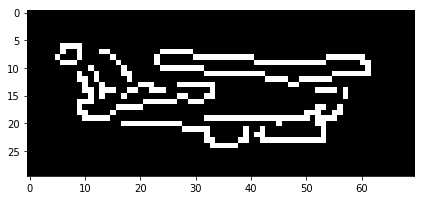

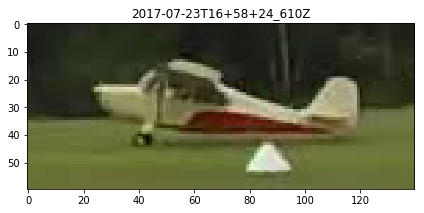

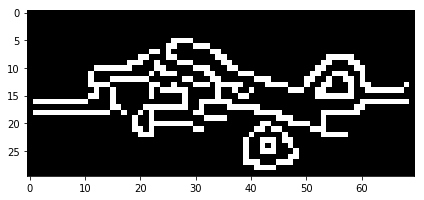

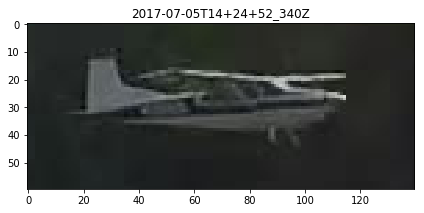

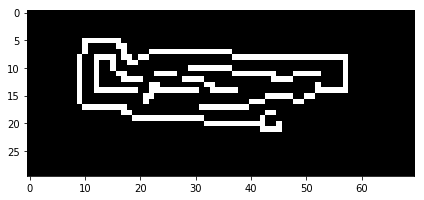

In [133]:
performance_examples('TP', nn_img_indices_to_view)

## false positives

2016-12-09T15+21+50_430Z
2016-11-20T18+17+46_910Z


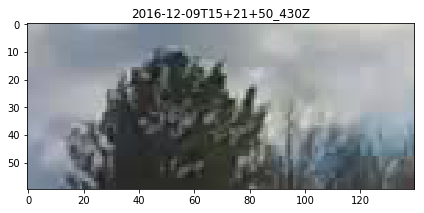

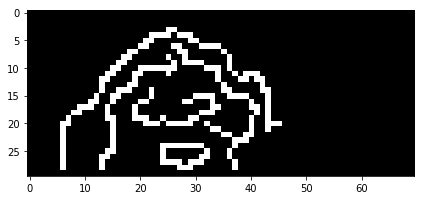

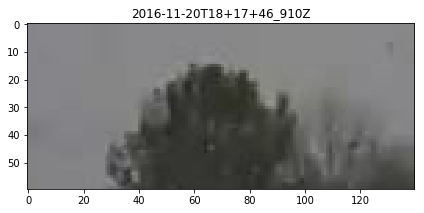

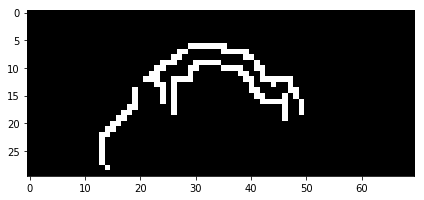

In [134]:
performance_examples('FP', nn_img_indices_to_view)

## false negatives

2017-07-09T15+59+51_510Z
2016-10-07T17+44+06_330Z
2017-06-28T18+23+15_110Z
2017-09-26T15+12+02_130Z
2017-02-04T19+28+21_630Z
2017-09-18T19+59+22_050Z
2017-07-05T23+05+37_890Z
2017-06-28T13+18+49_610Z
2016-08-28T13+58+11_200Z
2017-07-12T17+56+20_210Z
2016-11-12T19+05+51_000Z
2017-07-09T18+27+26_140Z
2017-10-19T15+43+17_790Z
2016-10-19T20+06+45_590Z
2017-12-01T15+51+08_650Z
2017-06-28T18+20+25_840Z
2017-11-23T12+49+59_380Z
2017-08-25T23+25+36_990Z
2016-10-07T17+52+56_250Z


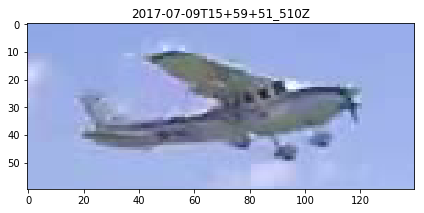

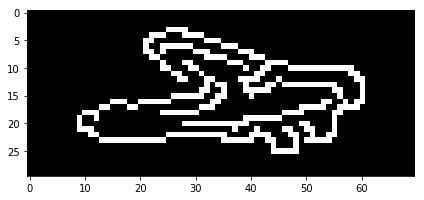

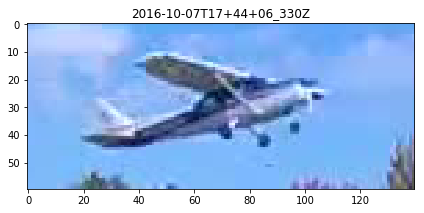

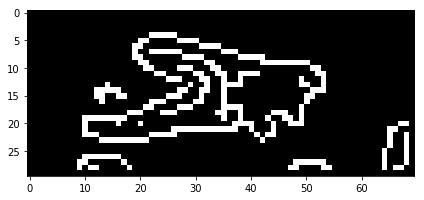

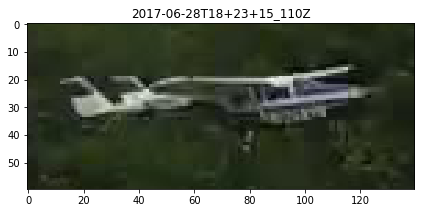

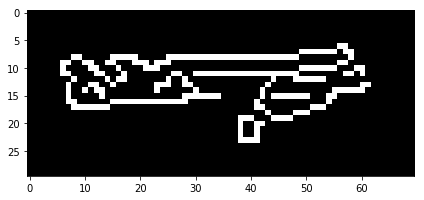

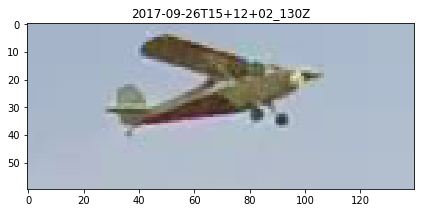

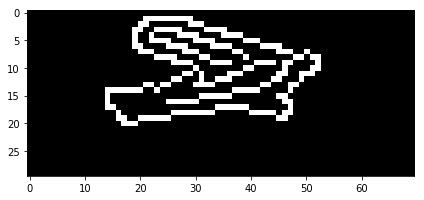

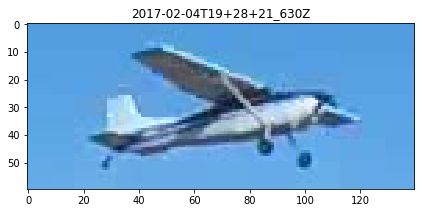

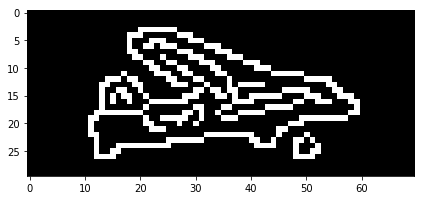

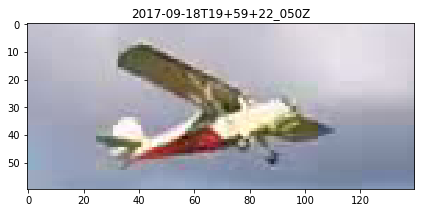

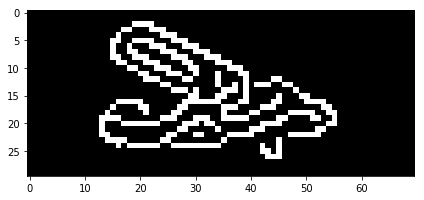

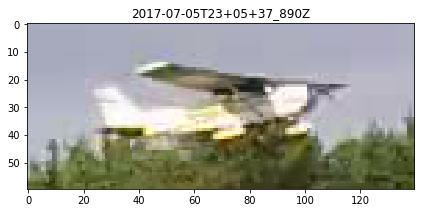

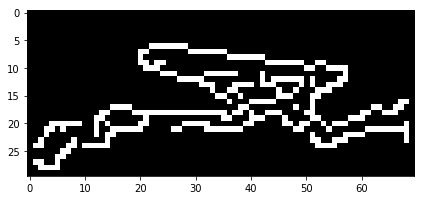

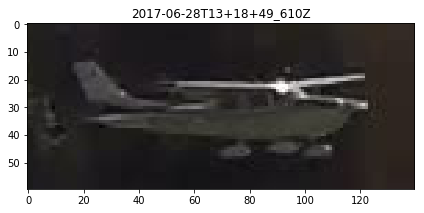

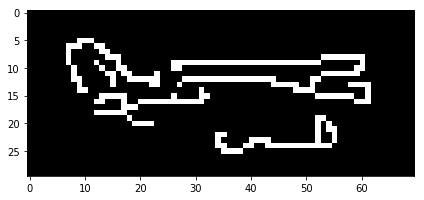

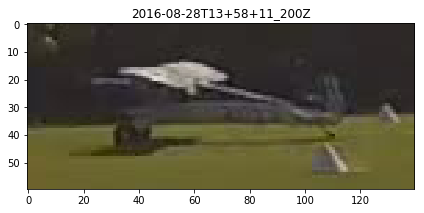

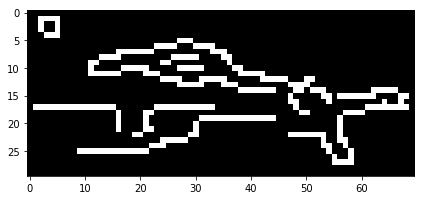

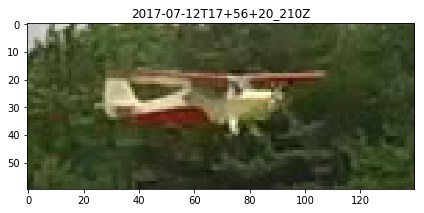

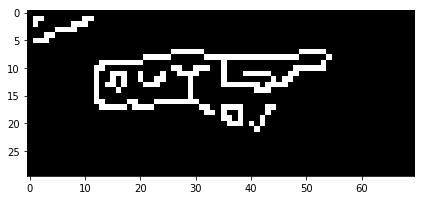

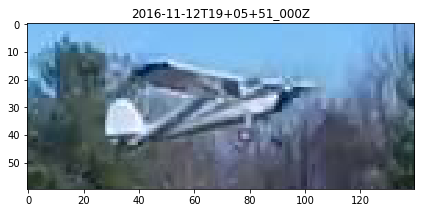

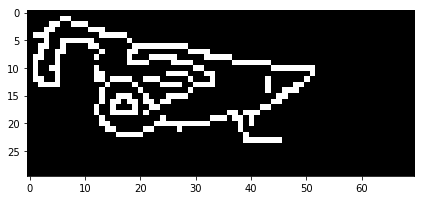

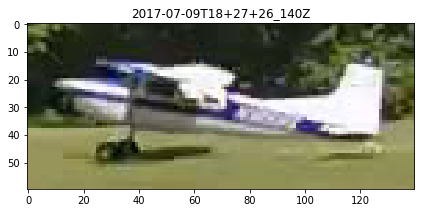

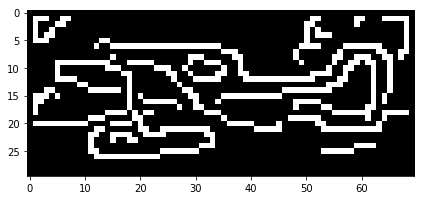

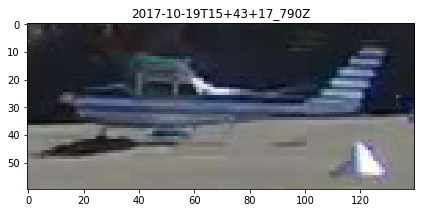

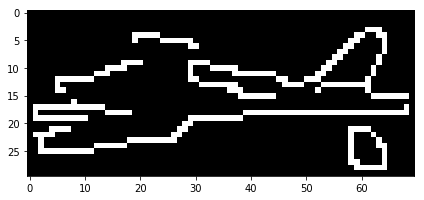

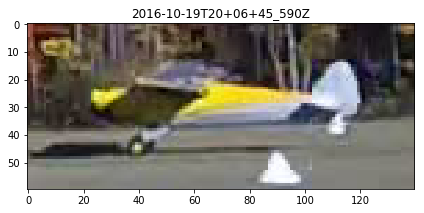

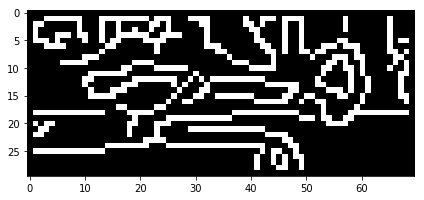

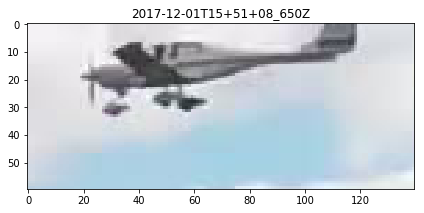

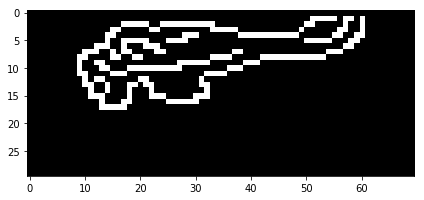

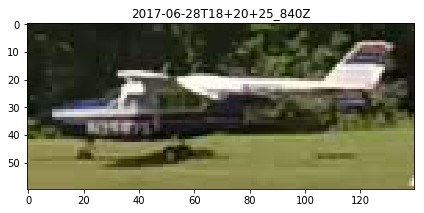

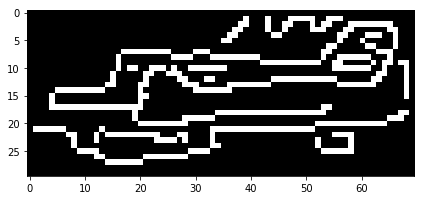

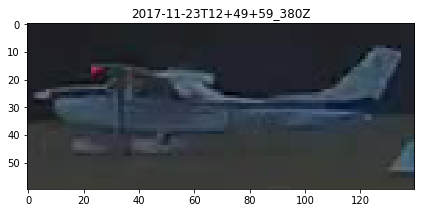

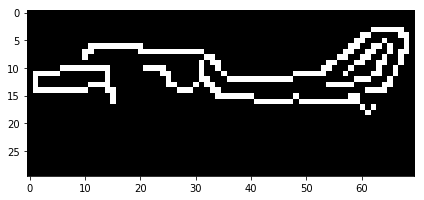

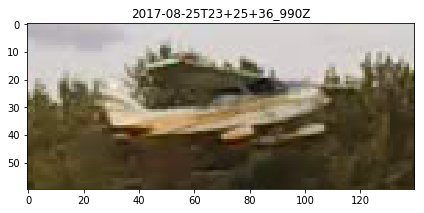

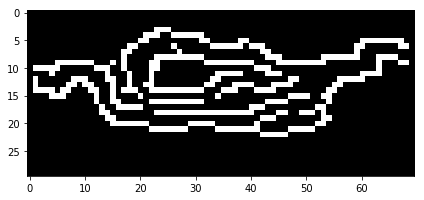

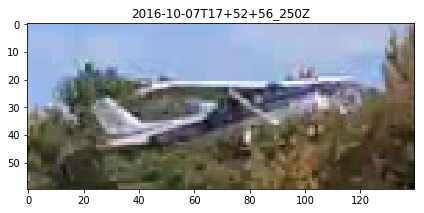

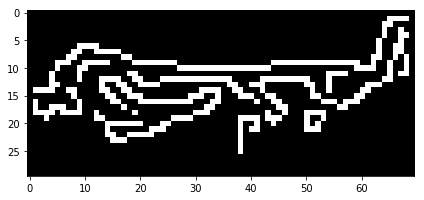

In [135]:
performance_examples('FN', nn_img_indices_to_view)

# comparisons

In [136]:
# list of fits to compare: 
final_fits = []
final_fits.append(prc_performance.performance_measures)
final_fits.append(prc_performance_test.performance_measures)
final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)

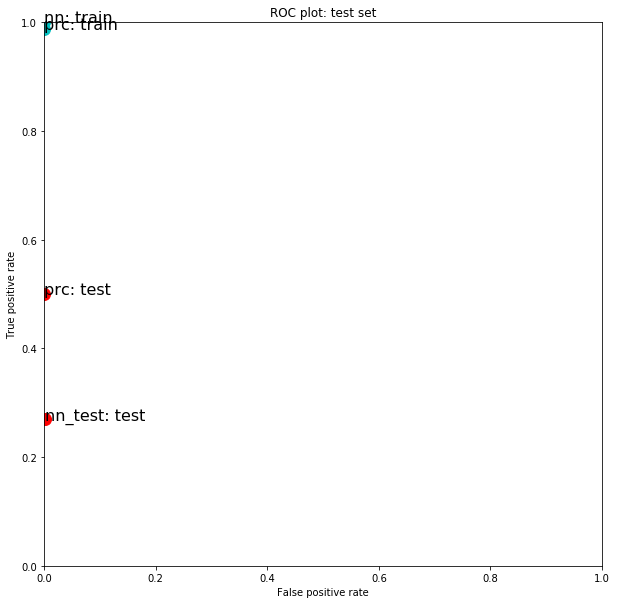

In [137]:
plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
